In [1]:
# 1. import lib
import numpy as np
import pandas as pd
# text => processing
import re
import string
import nltk
from nltk.corpus import stopwords

# sklearn
from sklearn import preprocessing, decomposition, model_selection, pipeline, metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

# visual
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
#2. load data
# training data
train = pd.read_csv('train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# testing data
test = pd.read_csv('test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
# 3 data about data => EDA
train.shape

(7613, 5)

In [5]:
test.shape

(3263, 4)

In [6]:
# missing data
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
# target

train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

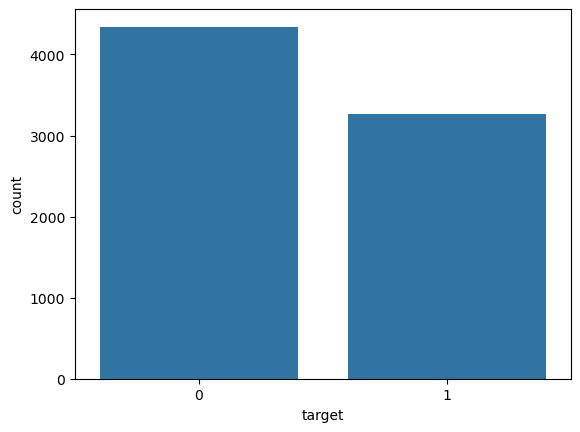

In [9]:
sns.barplot(x = train['target'].value_counts().index, y=train['target'].value_counts())

<Axes: xlabel='count', ylabel='keyword'>

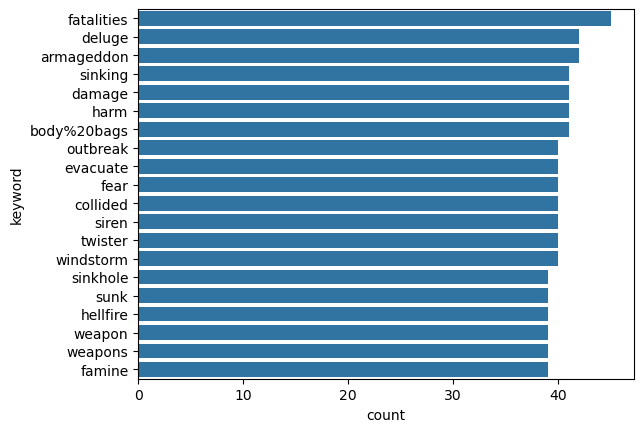

In [10]:
# keyword
sns.barplot(y = train['keyword'].value_counts()[:20].index,x = train['keyword'].value_counts()[:20], orient = 'h')

<Axes: xlabel='count', ylabel='location'>

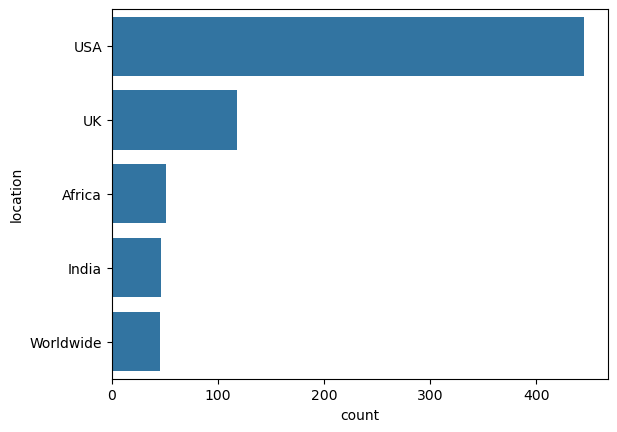

In [11]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
sns.barplot(y = train['location'].value_counts()[:5].index,x = train['location'].value_counts()[:5], orient = 'h')

In [12]:
# 4. Text Preprocessing
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [13]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x:clean_text(x)) 
test['text'] = test['text'].apply(lambda x:clean_text(x)) 
train['text'][:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [14]:
#pip install wordcloud

In [15]:
from wordcloud import WordCloud

In [16]:
# tweet
disaster_tweet = train[train['target']==1]['text']
non_disaster_tweet = train[train['target']==0]['text']

In [17]:
disaster_tweet.values[10]

'three people died from the heat wave so far'

In [18]:
non_disaster_tweet.values[1]

'i love fruits'

Text(0.5, 1.0, 'Non_Disaster Tweets')

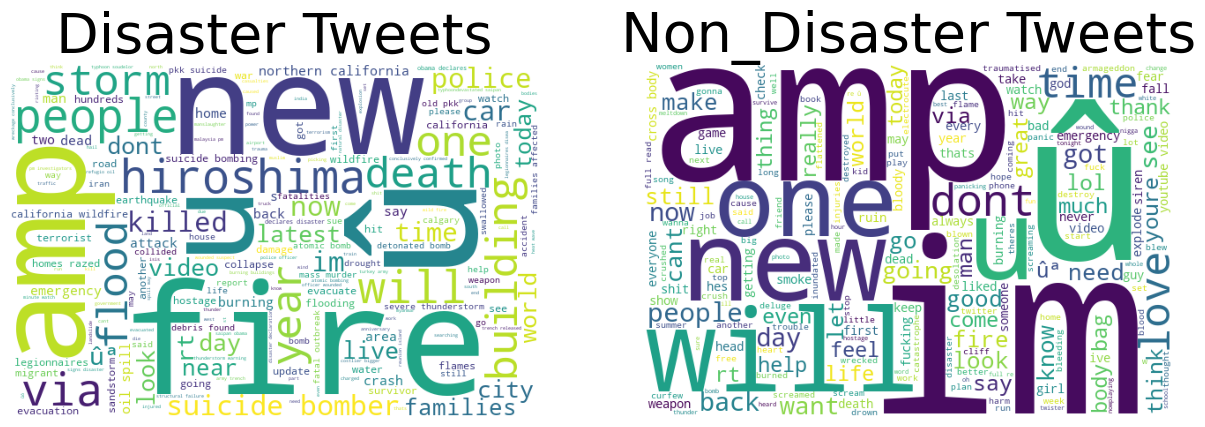

In [19]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize = [15,5])
# ax1 = > disaster
word_cloud_1 = WordCloud(background_color='white',width = 600, height = 400).generate(" ".join(disaster_tweet))
ax1.imshow(word_cloud_1)
ax1.axis("off")
ax1.set_title("Disaster Tweets", fontsize = 40)
# ax2 = > non_disaster
word_cloud_2 = WordCloud(background_color='white',width = 600, height = 400).generate(" ".join(non_disaster_tweet))
ax2.imshow(word_cloud_2)
ax2.axis("off")
ax2.set_title("Non_Disaster Tweets", fontsize = 40)

In [20]:
text = "Are you Learning, isn't it"

token_1 = nltk.tokenize.WhitespaceTokenizer()
token_2 = nltk.tokenize.TreebankWordTokenizer()
token_3 = nltk.tokenize.WordPunctTokenizer()
token_4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("example: ", text)
print()
print("white space: ", token_1.tokenize(text))

print()
print("tree bank: ", token_2.tokenize(text))

print()
print("word punct: ", token_3.tokenize(text))

print()
print("regular express: ", token_4.tokenize(text))


example:  Are you Learning, isn't it

white space:  ['Are', 'you', 'Learning,', "isn't", 'it']

tree bank:  ['Are', 'you', 'Learning', ',', 'is', "n't", 'it']

word punct:  ['Are', 'you', 'Learning', ',', 'isn', "'", 't', 'it']

regular express:  ['Are', 'you', 'Learning', 'isn', 't', 'it']


In [21]:
# tokinizing

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['text'] = train['text'].apply(lambda x:tokenizer.tokenize(x)) 
test['text'] = test['text'].apply(lambda x:tokenizer.tokenize(x)) 
train['text'][:5]

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [22]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x:remove_stopwords(x)) 
test['text'] = test['text'].apply(lambda x:remove_stopwords(x)) 
train['text'][:5]


0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [23]:
text = "feet cats wolves talked"
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

stemmer = nltk.stem.PorterStemmer()
print("stemming: ", " ".join(stemmer.stem(token) for token in tokens))

lemmatizer = nltk.stem.WordNetLemmatizer()
print("Lemmatizing: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

stemming:  feet cat wolv talk
Lemmatizing:  foot cat wolf talked


In [24]:
def combine_text(list_of_text):
    combined_text = " ".join(list_of_text)
    return combined_text
train['text'] = train['text'].apply(lambda x:combine_text(x)) 
test['text'] = test['text'].apply(lambda x:combine_text(x)) 
train['text']
    

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                       volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [25]:
# getting all together

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    non_punc = clean_text(text)
    tokenized_text = tokenizer.tokenize(non_punc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = " ".join(remove_stopwords)
    return combined_text
    

5. Bag of Words

In [52]:
count_vector = CountVectorizer()
train_vector = count_vector.fit_transform(train['text'])
test_vector = count_vector.fit_transform(test['text'])

print(train_vector[0].todense())

[[0 0 0 ... 0 0 0]]


In [54]:
tfidf = TfidfVectorizer(min_df=2,max_df=.5, ngram_range=(1,2))# 1=> tf-idf, tf*idf
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.fit_transform(test['text'])

In [56]:
print(train_tfidf[0].todense())

[[0. 0. 0. ... 0. 0. 0.]]


6. Building the Text Classification Model

In [67]:
clf = LogisticRegression(C = 1.0) # C => inverse of Regularization strength. def = > C=1
scores = model_selection.cross_val_score(clf,train_vector, train['target'], cv = 5, scoring = 'f1')
scores

array([0.6021093 , 0.49827586, 0.57118787, 0.56744186, 0.68839428])

In [69]:
clf.fit(train_vector, train['target']) 

LogisticRegression()

In [71]:
clf_tfidf = LogisticRegression(C = 1.0) # C => inverse of Regularization strength. def = > C=1
scores = model_selection.cross_val_score(clf_tfidf,train_tfidf, train['target'], cv = 5, scoring = 'f1')
scores

array([0.57229525, 0.4972067 , 0.54093836, 0.46618106, 0.65360641])

it appears the Countverctorizer gives better performance than TFIDF

In [76]:
def submission(sub_file_path, model, test_vector):
    sample_sub = pd.read_csv(sub_file_path)
    sample_sub[target] = model.predict(test_vector)
    sample_sub.to_csv("submission.csv", index=False)

In [78]:
sub_file_path = "C:/Users/AJANTHA/Downloads/Python_Introduction/Guvi_2025/NLP"
test_vectors = test_tfidf
submission(sub_file_path, clf_tfidf, test_vectors)

PermissionError: [Errno 13] Permission denied: 'C:/Users/AJANTHA/Downloads/Python_Introduction/Guvi_2025/NLP'